# Compare models trained with and without an attention region

## Set-up

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 52.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import pandas as pd
import numpy as np
from fastai.vision import *

In [ ]:
def composition(df, column):
  info = pd.DataFrame(columns=['label', 'count', 'percent'])

  counts = df[column].value_counts()
  percents = df[column].value_counts(normalize=True) * 100
  labels = np.unique(df[column])

  for label in labels:
    info = info.append({
        'label': label,
        'count': counts[label],
        'percent': percents[label]
        },
        ignore_index=True)
  
  return info

## Compare models

#### Set-up

In [ ]:
path = '/gdrive/My Drive/Labeling'
model_path = os.path.join(path, 'Model')
image_path_original = os.path.join(model_path, 'Images')
image_path_attention = os.path.join(path, 'Segmentation', 'Predictions', 'AttentionRegion', '0')
image_path_attention_255 = os.path.join(path, 'Segmentation', 'Predictions', 'AttentionRegion', '255')

#### Load the test set

In [ ]:
labels = pd.read_csv(os.path.join(path, 'LabelsCSV', 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
test = labels[labels['dataset']=='test']

In [ ]:
print(len(labels))
print(len(test))

5375
886


#### Check the composition of the test set

In [ ]:
composition(test, 'group_2')

,label,count,percent
0,0.0,662.0,74.717833
1,1.0,224.0,25.282167


In [ ]:
composition(test, 'group_4')

,label,count,percent
0,0.0,353.0,39.841986
1,1.0,333.0,37.584650
2,2.0,166.0,18.735892
3,3.0,34.0,3.837472


#### v18_original

In [ ]:
# Test set
test_v18 = test.filter(items=['image', 'group_2'])
test_v18['group_2'] = test_v18['group_2'].astype(int).astype(str)
test_v18['is_valid'] = True

# Placeholder training data to load into the model
test_v18_train = test_v18.copy(deep=True)
test_v18_train['is_valid'] = False
test_v18_train = test_v18_train[0:64]

test_v18 = test_v18.append(test_v18_train)

In [ ]:
print(len(test_v18))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_original, df=test_v18)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v18', 'v18-original-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.6828)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

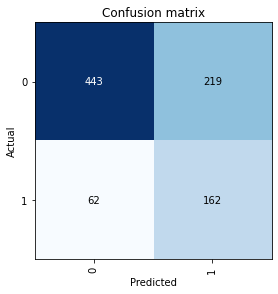

In [ ]:
interp.plot_confusion_matrix()

#### v18_attention

In [ ]:
# Test set
test_v18 = test.filter(items=['image_mask', 'group_2'])
test_v18['group_2'] = test_v18['group_2'].astype(int).astype(str)
test_v18['is_valid'] = True

# Placeholder training data to load into the model
test_v18_train = test_v18.copy(deep=True)
test_v18_train['is_valid'] = False
test_v18_train = test_v18_train[0:64]

test_v18 = test_v18.append(test_v18_train)

In [ ]:
print(len(test_v18))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_attention, df=test_v18)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v18', 'v18-attention-stage-2-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.4955)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

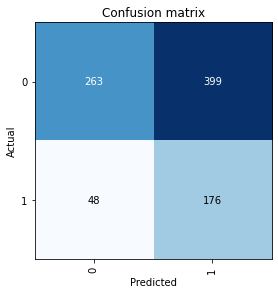

In [ ]:
interp.plot_confusion_matrix()

#### v18_attention_255

In [ ]:
# Test set
test_v18 = test.filter(items=['image_mask', 'group_2'])
test_v18['group_2'] = test_v18['group_2'].astype(int).astype(str)
test_v18['is_valid'] = True

# Placeholder training data to load into the model
test_v18_train = test_v18.copy(deep=True)
test_v18_train['is_valid'] = False
test_v18_train = test_v18_train[0:64]

test_v18 = test_v18.append(test_v18_train)

In [ ]:
print(len(test_v18))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_attention_255, df=test_v18)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v18', 'v18-attention-255-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.6738)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

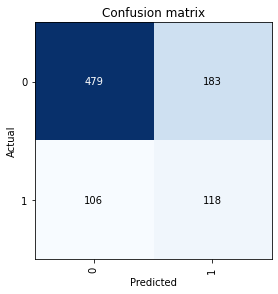

In [ ]:
interp.plot_confusion_matrix()

#### v19_original

In [ ]:
# Test set
test_v19 = test.filter(items=['image', 'group_4'])
test_v19['group_4'] = test_v19['group_4'].astype(int).astype(str)
test_v19['is_valid'] = True

# Placeholder training data to load into the model
test_v19_train = test_v19.copy(deep=True)
test_v19_train['is_valid'] = False
test_v19_train = test_v19_train[0:64]

test_v19 = test_v19.append(test_v19_train)

In [ ]:
print(len(test_v19))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_original, df=test_v19)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v19', 'v19-original-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.5519)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

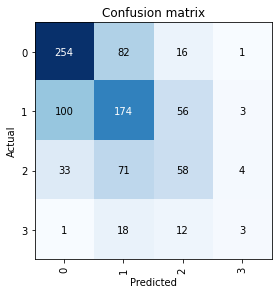

In [ ]:
interp.plot_confusion_matrix()

#### v19_attention

In [ ]:
# Test set
test_v19 = test.filter(items=['image_mask', 'group_4'])
test_v19['group_4'] = test_v19['group_4'].astype(int).astype(str)
test_v19['is_valid'] = True

# Placeholder training data to load into the model
test_v19_train = test_v19.copy(deep=True)
test_v19_train['is_valid'] = False
test_v19_train = test_v19_train[0:64]

test_v19 = test_v19.append(test_v19_train)

In [ ]:
print(len(test_v19))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_attention, df=test_v19)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v19', 'v19-attention-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.4492)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

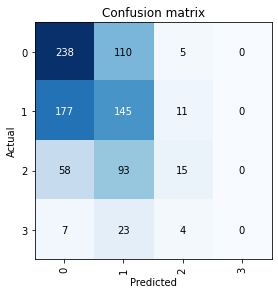

In [ ]:
interp.plot_confusion_matrix()

#### v19_attention_255

In [ ]:
# Test set
test_v19 = test.filter(items=['image_mask', 'group_4'])
test_v19['group_4'] = test_v19['group_4'].astype(int).astype(str)
test_v19['is_valid'] = True

# Placeholder training data to load into the model
test_v19_train = test_v19.copy(deep=True)
test_v19_train['is_valid'] = False
test_v19_train = test_v19_train[0:64]

test_v19 = test_v19.append(test_v19_train)

In [ ]:
print(len(test_v19))

950


In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path_attention_255, df=test_v19)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(size=(270,480))
        .databunch(bs=1)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

64 64
886 886


In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy])

In [ ]:
learn.load(os.path.join(model_path, 'attention_region', 'v19', 'v19-attention-255-stage-2'))

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
accuracy(preds, ys)

tensor(0.4244)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

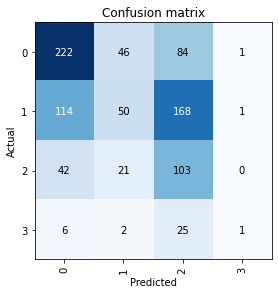

In [ ]:
interp.plot_confusion_matrix()

#### Confusion matrix to accuracy by class

In [ ]:
def accuracy_by_class(cm):
  accuracies = []

  for i in range(len(cm)):
    row_total = 0
    num_correct = 0
    for j in range(len(cm[0])):
      row_total += cm[i][j]
      if i == j:
        num_correct = cm[i][j]
    
    accuracy = round((num_correct/row_total) * 100, 2)
    accuracies.append(accuracy)
    print('Class', i, ':', accuracy)
  
  print('Average:', round(sum(accuracies) / len(accuracies), 2))

In [ ]:
cm_v18_original = [[443, 219], [62, 162]]
accuracy_by_class(cm_v18_original)

Class 0 : 66.92
Class 1 : 72.32
Average: 69.62


In [ ]:
cm_v18_attention = [[263, 399], [48, 176]]
accuracy_by_class(cm_v18_attention)

Class 0 : 39.73
Class 1 : 78.57
Average: 59.15


In [ ]:
cm_v18_attention_255 = [[479, 183], [106, 118]]
accuracy_by_class(cm_v18_attention_255)

Class 0 : 72.36
Class 1 : 52.68
Average: 62.52


In [ ]:
cm_v19_original = [[254, 82, 16, 1],
                   [100, 174, 56, 3],
                   [33, 71, 58, 4],
                   [1, 18, 12, 3]]
accuracy_by_class(cm_v19_original)

Class 0 : 71.95
Class 1 : 52.25
Class 2 : 34.94
Class 3 : 8.82
Average: 41.99


In [ ]:
cm_v19_attention = [[238, 110, 5, 0],
                   [177, 145, 11, 0],
                   [58, 93, 15, 0],
                   [7, 23, 4, 0]]
accuracy_by_class(cm_v19_attention)

Class 0 : 67.42
Class 1 : 43.54
Class 2 : 9.04
Class 3 : 0.0
Average: 30.0


In [ ]:
cm_v19_attention_255 = [[222, 46, 84, 1],
                   [114, 50, 168, 1],
                   [42, 21, 103, 0],
                   [6, 2, 25, 1]]
accuracy_by_class(cm_v19_attention_255)

Class 0 : 62.89
Class 1 : 15.02
Class 2 : 62.05
Class 3 : 2.94
Average: 35.72
